In [ ]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [ ]:
import numpy as np
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask, z_score_normalize
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model, save_model, train_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
hr_data_path='input_data/deg/0_5x0_5/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (160, 290)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, LeakyReLU, Lambda, Conv2DTranspose, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

dem_data_1 = np.load("luse_and_dem/dem_1.npy")
dem_data_1 = z_score_normalize(dem_data_1, np.mean(dem_data_1), np.var(dem_data_1))

# Convert to TensorFlow Constants
dem_tensor_1 = tf.constant(dem_data_1, dtype=tf.float32)
dem_tensor_1 = tf.expand_dims(dem_tensor_1, axis=-1)

def expand_static_data_dem_1(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(dem_tensor_1, 0), [batch_size, 1, 1, 1])

dem_data_0_5 = np.load("luse_and_dem/dem_0_5.npy")
dem_data_0_5 = z_score_normalize(dem_data_0_5, np.mean(dem_data_0_5), np.var(dem_data_0_5))

# Convert to TensorFlow Constants
dem_tensor_0_5 = tf.constant(dem_data_0_5, dtype=tf.float32)
dem_tensor_0_5 = tf.expand_dims(dem_tensor_0_5, axis=-1)

def expand_static_data_dem_0_5(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(dem_tensor_0_5, 0), [batch_size, 1, 1, 1])

# Residual Block (Keeping Filters Constant)
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = Lambda(lambda t: t * scaling)(res)  # Scale residual output
    return Add()([x, res])  # Skip connection within residual block

def create_edsr():
    input_img = Input(shape=(80, 145, 1))  # Low-resolution input

    dem_input = Lambda(expand_static_data_dem_1, output_shape=(80, 145, 1))(input_img)
    dem_output = Lambda(expand_static_data_dem_0_5, output_shape=(160, 290, 1))(input_img)

    # Concatenate the static
    x = Concatenate()([input_img, dem_input])

    # Initial Conv Layer
    initial_conv = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    # x = LeakyReLU(alpha=0.2)(x)

    # Residual Blocks (Feature Extraction)
    x = residual_block(initial_conv, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)

    x = Add()([x, initial_conv])

    # Upsampling Layer moved to the end
    x = UpSampling2D(size=(2, 2))(x)  # Upscale to (160, 290)

    # Concatenate Upscaled Temperature with DEM
    x = Concatenate()([x, dem_output])

    # Fusion Layers
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)

    # Final Conv Layer (Reduces to 1 Output Channel)
    output_img = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam', loss='mae', metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [ ]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(21478, 80, 145, 1)
(21478, 160, 290, 1)
(4602, 80, 145, 1)
(4602, 160, 290, 1)


In [ ]:
# Initialize the model
edsr_model = create_edsr()
edsr_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80, 145, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 80, 145, 1)     │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 80, 145, 2)     │              0 │ input_layer[0][0],     │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 145, 32)    │            608 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 80, 145, 32)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 80, 145, 32)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 80, 145, 32)    │              0 │ conv2d[0][0],          │
│                           │                        │                │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 80, 145, 32)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 80, 145, 32)    │              0 │ add[0][0],             │
│                           │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 80, 145, 32)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 98,145 (383.38 KB)

 Trainable params: 98,145 (383.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 64s 242ms/step - loss: 0.0243 - mae: 0.0243 - mse: 0.0028 - psnr: 29.4295 - ssim: 0.8776 - val_loss: 0.0076 - val_mae: 0.0076 - val_mse: 2.2906e-04 - val_psnr: 36.4009 - val_ssim: 0.9580 - learning_rate: 0.0010
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0074 - mae: 0.0074 - mse: 2.0485e-04 - psnr: 36.9061 - ssim: 0.9587 - val_loss: 0.0068 - val_mae: 0.0068 - val_mse: 1.6680e-04 - val_psnr: 37.7783 - val_ssim: 0.9607 - learning_rate: 0.0010
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0068 - mae: 0.0068 - mse: 1.6571e-04 - psnr: 37.8078 - ssim: 0.9608 - val_loss: 0.0065 - val_mae: 0.0065 - val_mse: 1.5703e-04 - val_psnr: 38.0405 - val_ssim: 0.9619 - learning_rate: 0.0010
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 0.0066 - mae: 0.0066 - mse: 1.5694e-04 - psnr: 38.0434 - ssim: 0.9619 - val_loss: 0.0064 - val_mae: 0.0064 - val_mse: 1.5115e-04 - val_psnr: 38.2063 - val_ssim: 0.9627 

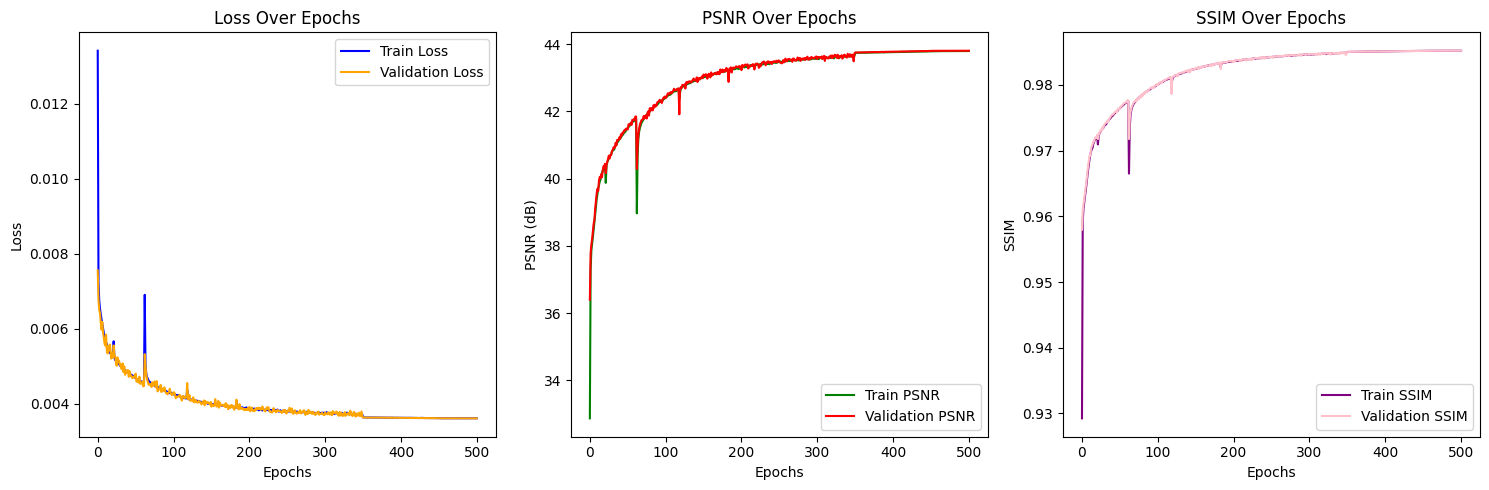

In [ ]:
import time

start_time = time.time()
history = train_model(edsr_model, trainX, trainY, valX, valY, 1000, 128, True, True, 150, 100)
end_time = time.time()

# Print the time taken
print(f"Training time: {end_time - start_time:.2f} seconds")


plot_history(history)
save_model(edsr_model, 'models/edsr_model_1to0_5_deg_dem.keras')

In [ ]:
edsr_model = tf.keras.models.load_model('models/edsr_model_1to0_5_deg_200epochs_dem_methods_combination.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [ ]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = edsr_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0036 - mae: 0.0036 - mse: 4.2467e-05 - psnr: 43.7247 - ssim: 0.9849
Test Loss: 0.003636694513261318
Test PSNR: 43.72550964355469
Test SSIM: 0.9849620461463928
Test MSE: 4.245931631885469e-05
Test MAE: 0.003636694513261318


In [ ]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = edsr_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


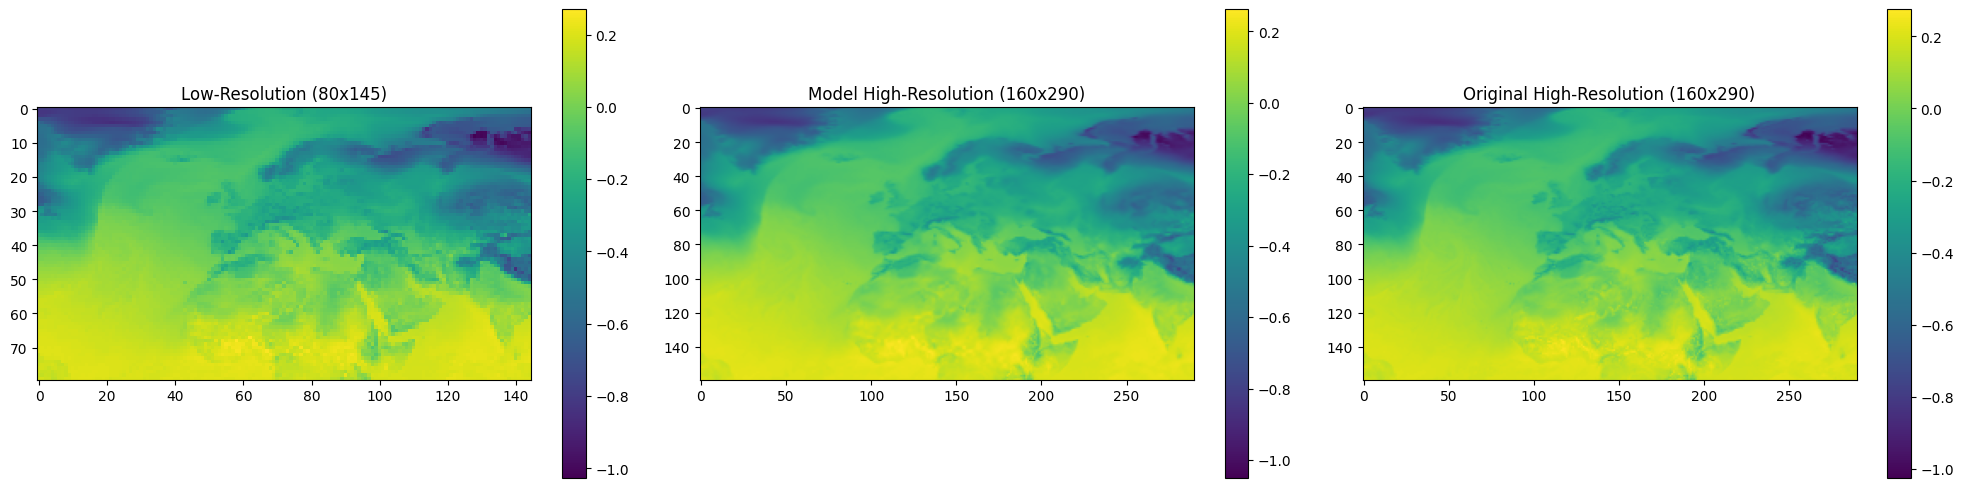

In [ ]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

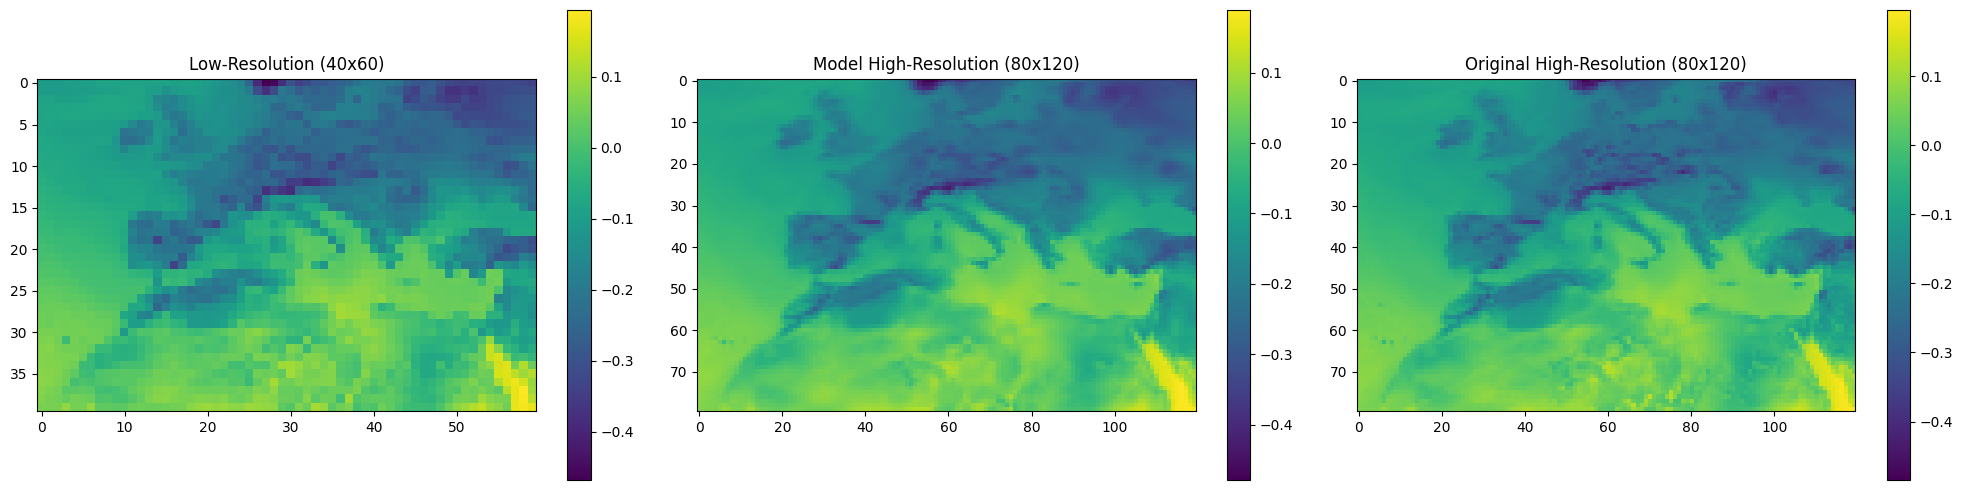

In [ ]:
plot_to_compare(low_res_input[20:60, 40:100], np.squeeze(high_res_data)[40:120, 80:200],  np.squeeze(high_res_output)[40:120, 80:200], 'viridis')

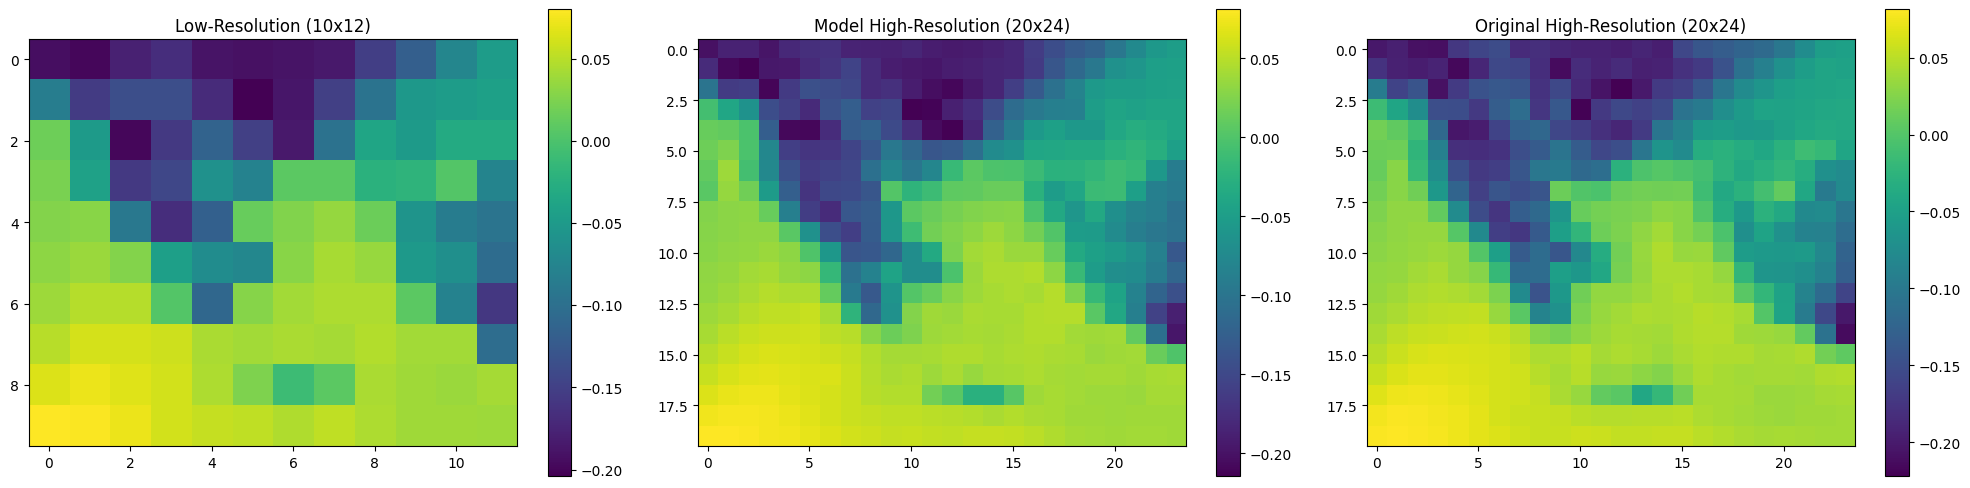

In [ ]:
plot_to_compare(low_res_input[36:46, 78:90], np.squeeze(high_res_data)[72:92, 156:180],  np.squeeze(high_res_output)[72:92, 156:180], 'viridis')

In [ ]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(edsr_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Per-pixel MSE shape: (160, 290, 1)
Per-pixel MAE shape: (160, 290, 1)
Per-pixel PSNR shape: (160, 290, 1)
Per-pixel SSIM shape: (160, 290, 1)
Mean Per-Pixel MSE: 4.245931e-05
Mean Per-Pixel MAE: 0.0036366945
Mean Per-Pixel PSNR: 47.968006
Mean Per-Pixel SSIM: 0.9956669


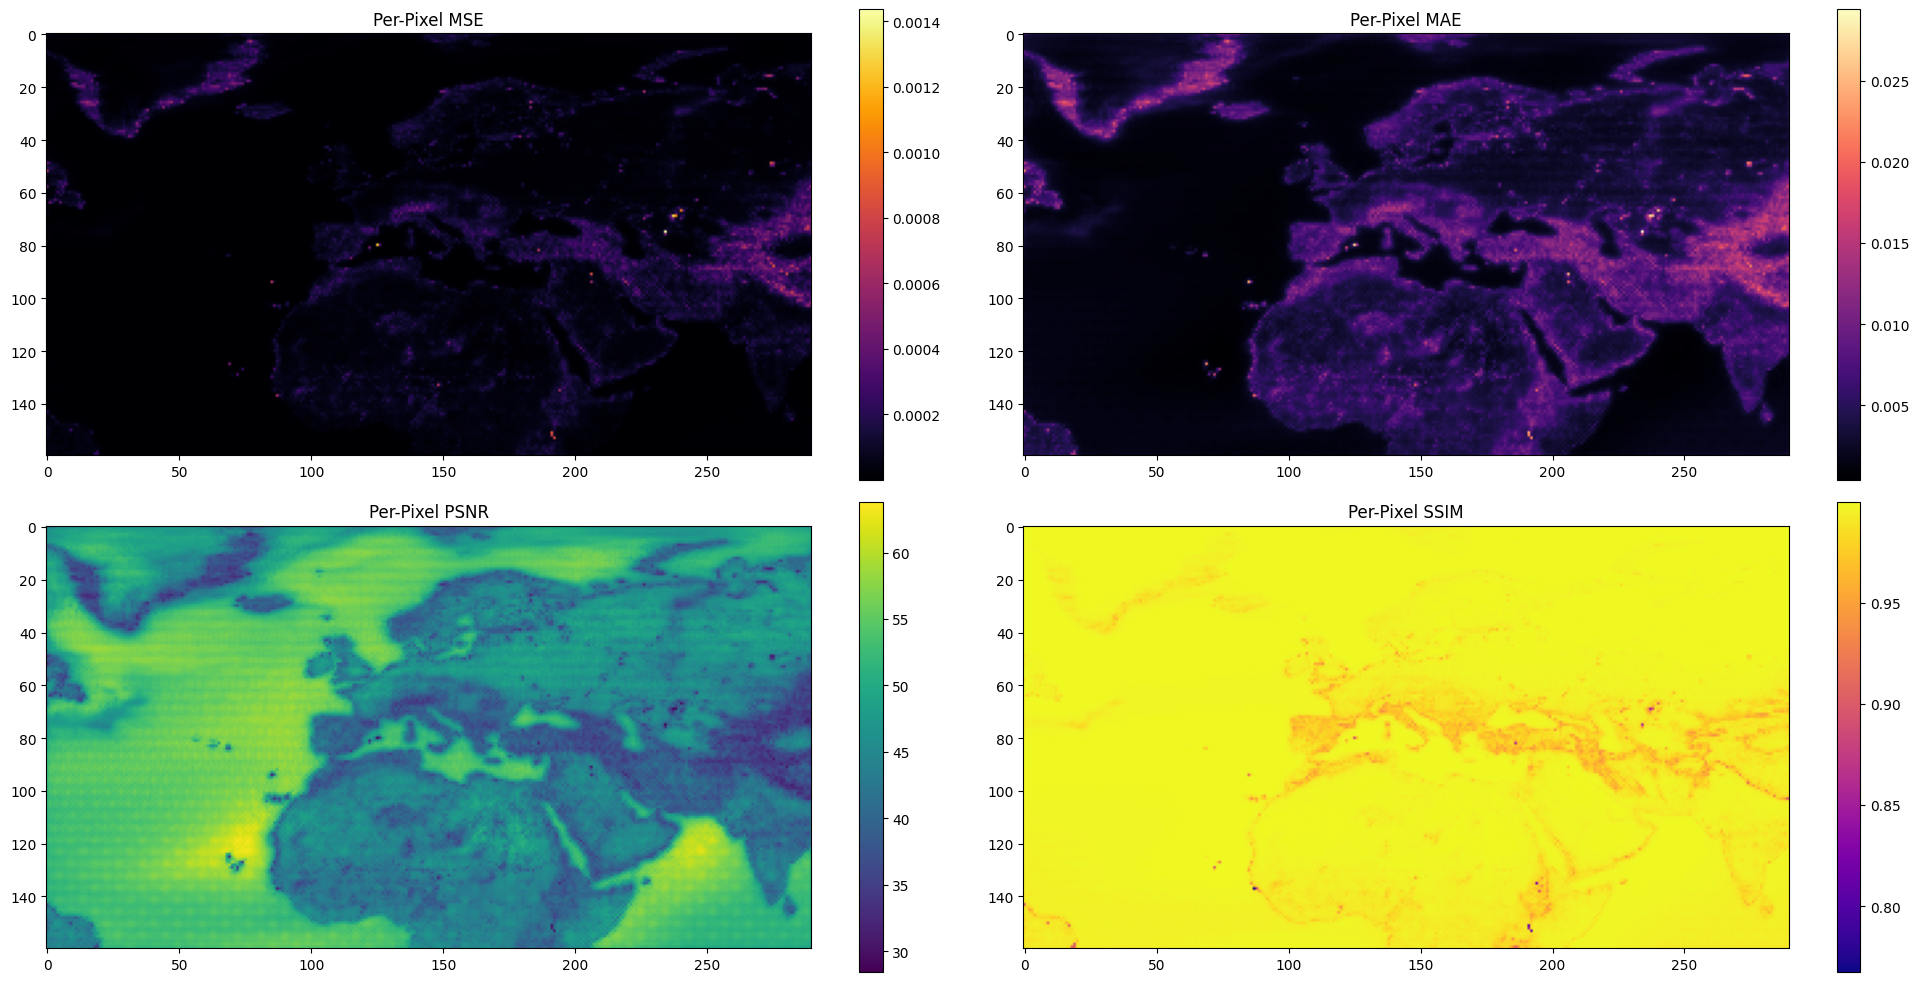

In [ ]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.23368238
Max Degrees MAE: 1.8896577
Min Degrees MAE: 0.027447307


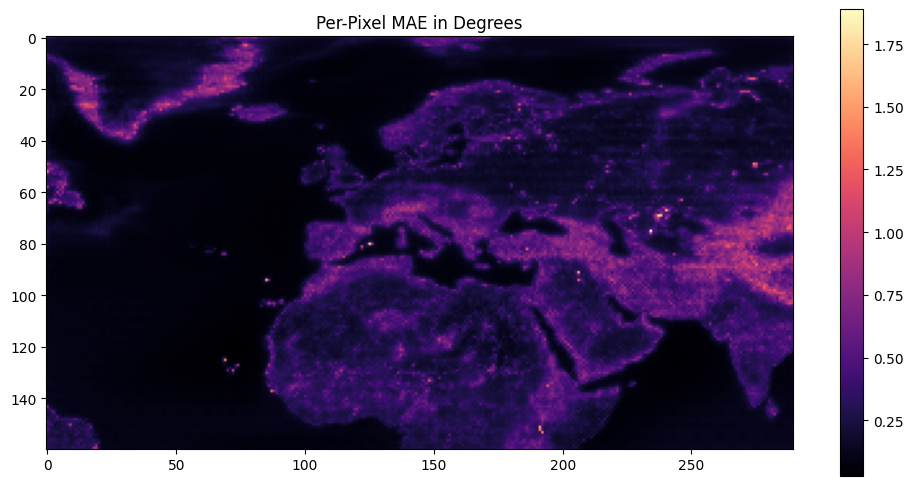

In [ ]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [ ]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_5'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_5'))

Mean Land-Pixels Degrees MAE: 0.3507037
Mean Land-Pixels MAE: 0.0054578446


In [ ]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_5'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_5'))

Mean Coastline-Pixels Degrees MAE: 0.4491382
Mean Costline-Pixels MAE: 0.0069897384
